# Capstone Project: Predictive Maintenance

In this notebook, we'll try to solve a predictive maintenance problem on Kaggle: [Kaggle Predictive Maintennace Competition](https://www.kaggle.com/c/predictive-maintenance1).

The dataset provides us with some error logs for an equipment: error counts, times of occurence...

The dataset consists of 2 files:
- feature.xlsx
- train_label.csv

The excel file has 983 lines. One line for each day. The covered time period is from 5/3/2015 (3rd of April 2015) to 1/17/2018 (17th of January 2018).

In the feature.csv file, for each day we have 5 sets of 26 features:
- errors counts (number of errors that day) for 26 types of errors
- errors max ticks (time of the last error of the day) for 26 types of errors
- errors min ticks (time of the first error of the day) for 26 types of errors
- errors mean tick (mean time for the errors of the day) for 26 types of errors
- errors standard deviation of the ticks for 26 types of errors

Total number of features in the feature.xlsx file is 26 * 5 + 1(date) = 131.

The train_label.csv file has 683 lines. One line for each day which presents only one label: 0 when equipment is OK, 1 when equipment failed that day. the covered period is from 5/3/2015 (3rd of April 2015) to 3/24/2017 (24th of March 2017).

The objective it to use the provided data to predict when the equipment will fail for the missing 300 days in the train_labels.csv file: from 3/25/2017 to 1/17/2018.

# Workflow:

1. Visualization
    - Quick Exploration
    - Exploratory Visualization
2. Preprocessing
3. Scaling
4. Splitting dataset
5. Implementation of the benchmark model
6. Implementation of the selected model
7. Comparison between the 2 models

# 1. Vizualization:

## 1.1 Quick Exploration & Cleaning:

In [1]:
%matplotlib inline
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
from datetime import datetime                    # manages dates - needed to convert to dates for matplotlib
import seaborn as sns                            # viz

# Retrieve features and labels
features = pd.read_excel('feature.xlsx', skiprows=0, header=1, index_col=0, parse_dates=['date'])
label = pd.read_csv('train_label.csv', header=0, parse_dates=['date'])

# Number of lines read for each file
print('Size of training dataset:', len(features.index))
print('Number of features:', len(features.columns))
print('Size of training labels:', len(label.index))
print('Number of labels:', len(label.columns)-1) # -1 to remove the date

Size of training dataset: 983
Number of features: 131
Size of training labels: 684
Number of labels: 1


We can see that the number of labels is 684 and not 683, This is due to the fact that the first label of the labels file is empty. We will clean this for now.

Fist row is removed (date 05/03/2015 - 3rd of May 2015)

In [2]:
label = label.drop([0], axis=0)
print('Size of training labels:', len(label.index))
print('Number of labels:', len(label.columns)-1)

Size of training labels: 683
Number of labels: 1


The problem is that now the two dataframes are not symmetrical: Label starts at date 05/04/2015 - 4th of May 2015 and Features start at date 05/03/2015 - 3rd of May 2015.

In order to have the two dataframes with the same starting date, we also need to remove first row from features dataframe.

In [3]:
features = features.drop([0], axis=0)
print('Size of training features:', len(features.index))
print('Number of features:', len(features.columns))

Size of training features: 982
Number of features: 131


In [4]:
print('labels columns:', label.columns)
print('features columns:', features.columns)

labels columns: Index(['date', 'label'], dtype='object')
features columns: Index([       'date',     136088194,     136088202,     136088394,
           136088802,     136089546,     136110468,     136216674,
           136222202,     136222210,
       ...
       '136225010.4', '136675426.4', '136675626.4', '136676578.4',
       '136676650.4', '136676666.4', '136676682.4', '136676698.4',
       '136676714.4', '136676754.4'],
      dtype='object', length=131)


We can see that the columns names for features are not explicit and repeat. Pandas added a suffix for repeating columns (.1 for 1st repetition, .2 for second repetition ...).

First thing we will do here is rename columns and add explicit suffixes.

In [5]:
# In order to rename columns, we need to first convert columns from int names to string
features.columns = features.columns.astype(str)

# Preparing dictionaries that will be used for renaming columns
real_to_made_errors = {
    '136088194': 'error1', '136088202': 'error2', '136088394': 'error3',
    '136088802': 'error4', '136089546': 'error5', '136110468': 'error6',
    '136216674': 'error7', '136222202': 'error8', '136222210': 'error9',
    '136222234': 'error10', '136222250': 'error11', '136222882': 'error12',
    '136223186': 'error13', '136224578': 'error14', '136224586': 'error15',
    '136224978': 'error16', '136225010': 'error17', '136675426': 'error18',
    '136675626': 'error19', '136676578': 'error20', '136676650': 'error21',
    '136676666': 'error22', '136676682': 'error23', '136676698': 'erro24',
    '136676714': 'error25', '136676754': 'error26'   
}

# Inverse dict in case it is used
made_to_real_errors = {v: k for k, v in real_to_made_errors.items()}

# Suffixes dict
suffixes_dict = {'.1':'.max_tick', '.2':'.min_tick', '.3':'.mean_tick', '.4':'.std_dev_tick'}

# Remaining dicts
real_to_made_errors_max_tick = {k+'.1':v+suffixes_dict['.1'] for k, v in real_to_made_errors.items()}
real_to_made_errors_min_tick = {k+'.2':v+suffixes_dict['.2'] for k, v in real_to_made_errors.items()}
real_to_made_errors_mean_tick = {k+'.3':v+suffixes_dict['.3'] for k, v in real_to_made_errors.items()}
real_to_made_errors_std_dev_tick = {k+'.4':v+suffixes_dict['.4'] for k, v in real_to_made_errors.items()}


def rename_columns(df):
    df.rename(index=str, columns=real_to_made_errors, inplace=True)
    df.rename(index=str, columns=real_to_made_errors_max_tick, inplace=True)
    df.rename(index=str, columns=real_to_made_errors_min_tick, inplace=True)
    df.rename(index=str, columns=real_to_made_errors_mean_tick, inplace=True)
    df.rename(index=str, columns=real_to_made_errors_std_dev_tick, inplace=True)

# Renaming
rename_columns(features)        

In order to view the descriptions of columns and statistics, we will split the features in five dataframes:
- features_count
- features_max
- features_min
- features_mean
- features_std_dev

That will allow a cleaner description and vizualization

In [6]:
# Preparing columns
cols_to_keep_for_counts = ['date'] + list(real_to_made_errors.values())
cols_to_keep_for_max = ['date'] + list(real_to_made_errors_max_tick.values())
cols_to_keep_for_min = ['date'] + list(real_to_made_errors_min_tick.values())
cols_to_keep_for_mean = ['date'] + list(real_to_made_errors_mean_tick.values())
cols_to_keep_for_std_dev = ['date'] + list(real_to_made_errors_std_dev_tick.values())

# Preparing 5 dataframes
features_count = features[cols_to_keep_for_counts] 
features_max = features[cols_to_keep_for_max] 
features_min = features[cols_to_keep_for_min] 
features_mean = features[cols_to_keep_for_mean] 
features_std_dev = features[cols_to_keep_for_std_dev] 

In [7]:
# Describing count dataframe
features_count.describe(include=[np.number])

,error1,error2,error3,error4,error5,error6,error7,error8,error9,error10,...,error17,error18,error19,error20,error21,error22,error23,erro24,error25,error26
count,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,...,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000,982.000000
mean,1.803462,0.568228,0.033605,0.469450,0.148676,593.344196,0.011202,4.502037,5.155804,0.102851,...,98.311609,0.260692,0.006110,0.369654,0.155804,0.662933,0.565173,0.701629,0.965377,24.369654
std,6.708513,11.685608,0.930780,3.042107,0.582004,3140.748782,0.264973,6.169001,9.730160,0.631013,...,483.464941,2.324199,0.119305,0.987597,1.206997,3.653358,2.789840,3.333880,4.500405,88.188340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,2.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,3.000000,2.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000,5.000000,7.000000,0.000000,...,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,89.000000,364.000000,29.000000,40.000000,6.000000,67425.000000,8.000000,67.000000,190.000000,13.000000,...,7801.000000,48.000000,3.000000,17.000000,22.000000,57.000000,36.000000,44.000000,62.000000,941.000000


In [ ]:
# Describing count dataframe
features_max.describe(include=[np.number])

In [ ]:
# Describing count dataframe
features_min.describe(include=[np.number])

In [ ]:
# Describing count dataframe
features_mean.describe(include=[np.number])

In [ ]:
# Describing count dataframe
features_std_dev.describe(include=[np.number])

In [ ]:
# Check total number of errors
print("Total number of errors in dataset is ", label['label'].sum())
print("Percentage of errors in dataset is {:.2f}%".format((label['label'].sum()/label['label'].count())*100))

## 1.2 Exploratory Visualization

Visualization was done without scaling bu the results were useless: 
- Different scales for each error stat
- Some error counts were simply undistinguishable from the other

That makes rescaling necessary to compare between the different error stats.

Besides, in order to visualize clearly we choose to focus only on errors count. And to have at most 3 error counts displayed in a graph.

The error counts will give us information on trends and seasonality. Indeed, the other stats (max, min, mean and std_dev) only give us details for the corresponding day but not through time.

We could see the error count as a macro indicator and the other stats (max, min, mean and std_dev) as micro stats.

In [ ]:
sns.set()

def rescale_element(x, min, max):
    return ((x - min)/(max - min))

#def get_failure_dates(label_df):
#    """Returns the indexes of equipment failure"""
#    return (label.date[label['label'] == 1].values)

def get_failure_indexes(label_df):
    """Returns list of indexes of days where equipment fails"""
    return label.index[label['label'] == 1].tolist()

def get_failure_only_label_dataframe(label_df):
    """Returns a dataframe containing only the equipment failures"""
    return label_df.loc[get_failure_indexes,:]

def rescale_column(df, col):
    """Scales values between 0 and 1"""
    min = df[col].min()
    max = df[col].max()
    return df[col].apply(rescale_element, args=(min,max))

def plot_dataframe(features_df, label_df, start, end, title, grid):
    """ Prints all 26 error types time series 
    and adds markers at dates where the equipment fails.
    start: must be greater or equal to 1 (index 1 is the date)
    end: must be less or equal to 27"""
    
    plt.figure(figsize=(15, 7))
    
    # Plots errors stats
    for col in list(features_df.columns)[start:end]:
        plt.plot(features_df.date.astype(datetime), rescale_column(features_df, col), label=col)
    
    # Plots vertical dotted lines
    #for date in get_failure_dates(label_df):
    #    plt.axvline(date, color="r", linestyle="--");
        
    # Plot equipment failures as big red points at y=0
    plt.plot(get_failure_only_label_dataframe(label_df).date.astype(datetime), 
             pd.Series(np.zeros(len(get_failure_indexes(label_df)))),#get_failure_only_label_dataframe(label_df).label-1, 
             "ko", markersize=5, label="failure")
    
    # Titles, Legends and formatting
    plt.title(title)
    plt.grid(grid)
    plt.legend(ncol=3, loc='upper left')
    plt.show()
    

# Plot all errors (4 error counts in same graph)
plot_dataframe(features_count, label, 1, 4, "Errors Count 1 to 3", True)
plot_dataframe(features_count, label, 4, 8, "Errors Count 4 to 7", True)
plot_dataframe(features_count, label, 8, 12, "Errors Count 8 to 11", True)
plot_dataframe(features_count, label, 12, 16, "Errors Count 12 to 15", True)
plot_dataframe(features_count, label, 16, 20, "Errors Count 16 to 19", True)
plot_dataframe(features_count, label, 20, 24, "Errors Count 20 to 23", True)
plot_dataframe(features_count, label, 24, 27, "Errors Count 24 to 26", True)

In [ ]:
def plot_figures_grid(features_df, label_df, ncols, nrows):
    """Plot each error in a separate graph"""

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, sharex=True)
    fig.set_size_inches((15, 30))
    for ind, col in enumerate(list(features_df.columns)[1:]):
        axeslist.ravel()[ind].plot(features_df.date.astype(datetime), rescale_column(features_df, col), label=col)
        axeslist.ravel()[ind].plot(get_failure_only_label_dataframe(label_df).date.astype(datetime), 
                 pd.Series(np.zeros(len(get_failure_indexes(label_df)))), 
                 "ko", markersize=2, label="failure")
        axeslist.ravel()[ind].set_title(col)
        axeslist.ravel()[ind].set_axis_off()
    #plt.tight_layout() # optional

# Plot figures in a grid
plot_figures_grid(features_count, label, 2, 13)

### Visualization results

From all the plots above we can notice three types of error_counts:
- Peaks: contains one or at most two peaks of errors throughout the time period (errors: 2, 3, 7, 19)
- Short-lived: has activvity during a limited amount of time - weeks or at most 6 months (errors: 6, 17, 22, 23, 24, 25, 26)
- Constant Activity: has activity throughout all the time period (errors: 1, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21)

It appears that the failures are not directly linked to a specific error count (all failures are not happening when we have peaks at error21 for example). 

However we can clearly see that some error counts peaks coincide with some failures (for example error5 and error8 seem to be correlated to the failures) so we can conclude that each failure is closely linked with a combination of error counts.

For trends we can see that the errors don't follow specific trends (increasing or decreasing over time).

For seasonality, apart from errors 5, 11 and 13 all error counts seem to be random. Further investigation could be done on that area but due to the submission deadline (today) I can unfortunately not go deeper for now.

# 2. Preprocessing

Definition of **stationarity**: 

**Stationarity** is one of the most important concepts when working with time series data. A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.

Let us understand this using an intuitive example. Consider the three plots shown below:
<img src="stationary_examples.png">

In the first plot, we can clearly see that the mean varies (increases) with time which results in an upward trend. Thus, this is a non-stationary series. For a series to be classified as stationary, it should not exhibit a trend.
Moving on to the second plot, we certainly do not see a trend in the series, but the variance of the series is a function of time. As mentioned previously, a stationary series must have a constant variance.
If you look at the third plot, the spread becomes closer as the time increases, which implies that the covariance is a function of time.

The three examples shown above represent non-stationary time series. Now let's look at another plot:
<img src="stationary_example.png">

In this case, the mean, variance and covariance are constant with time. This is what a stationary time series looks like.

Predicting future values using the latter plot would be easier. Indeed, most statistical models require the series to be stationary to make effective and precise predictions.

**Analyzing Correlations for error counts only**

The ticks represent the first, last, mean, stddev of the time of the day whem the errors occured. This data is repeating every day so we clearly expect a high correlation here.

For errors count, we need to see if they are correlated and we will apply a specific test for that: The Coint Johansen test. 

According to this [source](https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/), if this test returns values less than 1 in modulus, the features can be considered stationary.

We will apply this test for a lag of 1 as it was done in the source. This considers the stationarity with a lag of 1 day.

As the test only accepts 12 values for each call we will split the data in two subsets (columns 1 to 12 and columns 13 to 24). We will skip the remaining columns (25 and 26) for simplicity.

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
colums_1_to_12 = list(features_count.columns)[1:13]
colums_13_to_24 = list(features_count.columns)[14:25]
features_count_first_half = features_count[colums_1_to_12]
features_count_second_half = features_count[colums_13_to_24]

In [ ]:
coint_johansen(features_count_first_half,-1,1).eig

In [ ]:
coint_johansen(features_count_second_half,-1,1).eig

The values returned here are all less than 1 in modulus. **The multivariate time series can be considered stationary**

**Some simple preprocessing is also needed here:**
- **We will also remove error19 column in all tick dataframes as all its values are NaN/0**
- **We will only fill missing/non numerical values with 0 for all ticks**
- **We will also change the dataframe indexes to have dates instead of 1 to 982**

In [ ]:
# Remove error19 columns from all tick dataframes
features_max.drop(['error19.max_tick'], axis=1, inplace=True)
features_min.drop(['error19.min_tick'], axis=1, inplace=True)
features_mean.drop(['error19.mean_tick'], axis=1, inplace=True)
features_std_dev.drop(['error19.std_dev_tick'], axis=1, inplace=True)

# Convert all values to numeric types
features_count = features_count.apply(pd.to_numeric, errors='coerce')
features_max = features_max.apply(pd.to_numeric, errors='coerce')
features_min = features_min.apply(pd.to_numeric, errors='coerce')
features_mean = features_mean.apply(pd.to_numeric, errors='coerce')
features_std_dev = features_std_dev.apply(pd.to_numeric, errors='coerce')

# Filling missing values with 0
features_count = features_count.fillna(0)
features_max = features_max.fillna(0)
features_min = features_min.fillna(0) 
features_mean = features_mean.fillna(0)
features_std_dev = features_std_dev.fillna(0)


def replace_index_with_dates(df):
    """
        Too many problems with different date formats for labels and 
        features.
        This function makes sure that the index is the same date for features and
        labels.
    """
    #df.index = df.date
    #format='%d/%b/%Y:%H:%M:%S +0000'
    #pandas.date_range(start=None, end=None)
    df.set_index(pd.date_range(start='5/4/2015', periods=len(df.index)), inplace=True)
    #df.set_index(pd.DatetimeIndex(df['date']), inplace=True)
    df.drop(['date'], axis=1, inplace=True)
    

# Replacing index with date   
replace_index_with_dates(features_count)
replace_index_with_dates(features_max)
replace_index_with_dates(features_min)
replace_index_with_dates(features_mean)
replace_index_with_dates(features_std_dev)
replace_index_with_dates(label)

**TO NOTE**: 

Stationarity is mostly needed for our benchmark model (VAR) and not for our selected model. Neural Networks do not require stationarity.

"Neural networks excel at capturing complex relationships between features (in this case historical data), therefore neither trend nor seasonality removal was performed." -> see [article](https://github.com/shellshock1911/Sky-Cast-Capstone/blob/master/final_report.pdf)

# 3. Scaling

A simple scaler will be chosen here: **MinMax Scaler** from scikit-learn. It scales the values between 0 and 1.

In [ ]:
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Standard Scaler
error_count_scaler = MinMaxScaler()

# All columns but date
features_count_all_columns = list(features_count.columns)

# Apply Standard Scaler to errors count
features_count_scaled_nparray = error_count_scaler.fit_transform(features_count)
features_count_scaled = pd.DataFrame(features_count_scaled_nparray, index=features_count.index, columns=features_count.columns)

features_count_scaled.describe(include='all')

In [ ]:
# Standard Scaler
error_ticks_scaler = MinMaxScaler()

# Create a dataframe with all ticks stats (concatenate max_tick, min_tick, mean_tick, std_dev_tick)
all_ticks = pd.concat([features_max, features_min, features_mean, features_std_dev], axis=1)

# All columns but date
all_ticks_all_columns = list(all_ticks.columns)

# Apply Standard Scaler to errors count
all_ticks_scaled_nparray = error_ticks_scaler.fit_transform(all_ticks)
all_ticks_scaled = pd.DataFrame(all_ticks_scaled_nparray, index=all_ticks.index, columns=all_ticks.columns)

all_ticks_scaled.describe(include='all')

Now preparing dataset before splitting/implementation:
- Putting back errors count and ticks in the same dataframe
- Removing extra lines from the resulting dataframe (lines not having labels - 982 feature lines vs 683 label lines)

In [ ]:
# Now putting all features in the same dataframe
all_features_scaled = pd.concat([features_count_scaled, all_ticks_scaled], axis=1)
print("Features Dataframe Infos: ")
all_features_scaled.info()

# Checking labels
print("\nLabel Dataframe Infos: ")
label.info()

# 982 entries in features and 683 entries in labels

# We need to remove the last 299 rows of features
all_features_scaled.drop(all_features_scaled.tail(299).index,inplace=True)

# Checking features again
print("\nFeatures Dataframe Infos: ")
all_features_scaled.info()

# 4. Splitting datasets

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(all_features_scaled, label, test_size=0.2)

We also need to join the features and labels in the same dataframe as they will be forecast together. We will not treat this problem as classification problem where we use the features to predict equipment failure.

The features and the label will be forecast using the following two algorithms. We will then calculate the AUC metric.

In [ ]:
dataset_train = pd.concat([X_train, y_train], axis=1)
dataset_test = pd.concat([X_test, y_test], axis=1)

print(dataset_train.info())
print(dataset_test.info())

Result of splitting:
- **Training dataset length is 546**
- **Testing dataset length is 137**

These results (especially the testing dataset length) will be used for the VAR prediction.
For the VAR prediction the dataset will not be split but the whole dataset will be used to create a predicion dataset. More details will be given below.

In [ ]:
dataset_all_with_label = pd.concat([all_features_scaled, label], axis=1)

# 5. Implementation of the benchmark model

The benchmark model is the VAR algorithm. It is not in sklearn but in another python library called statsmodel.

While trying to use VAR with the above resulting datasets, we noticed that the VAR cannot work with constant columns. Although there were no constant columns before splitting the datasets to train & test. We now have constant columns in the training dataset.

We will then remove all constant columns to allow the VAR to apply to the data. This operation is specific to the  VAR algorithm, that is why it was not done above during the splitting (Step 4.)

In [ ]:
# Remove columns that are constant
dataset_all_with_label_var = dataset_all_with_label.loc[:, (dataset_all_with_label != dataset_all_with_label.iloc[0]).any()]

removed_columns = list()
for col in list(dataset_all_with_label.columns):
    if col not in (list(dataset_all_with_label_var.columns)):
        removed_columns.append(col)
        
print("removed columns : ", removed_columns)

In [ ]:
# Remaining features:
print(len(list(dataset_all_with_label_var.columns)))

The var algorithm expects many parameters but we focused on the following that we noted as the most important:
- The training dataset is needed at the VAR class instanciation
- Then the following 2 params during the algorithm fit call:
    - **maxlags**: the maximum number of steps (in the past) to take into account for the calculation ot the forecast/prediction. Exemple: 10 - take the last 10 days/steps values to do the prediction
    - **trend**: The type of the last element of the equation to calculate the forecast. The VAR equation uses the past elements of all features to calculate the next features and it adds an extra parameter (either a constant or a trend or both). Possible values for this parameter are: constant, constant and trend, constant linear and quadratic trend and eventually no constant. 
- At last the number of steps to predict is needed for the forecast call.  Example: 30 - forecast the next 30 days/steps.

**IMPORTANT**:

We tried to use the VAR algorithm to predict all the testing set at once (one forecast call) and get the AUC but the results were below 40%. The resulting label prediction was a few peaks for the first 3 days followed be a slowly decreasing line that always remained below 0.05. The prediction was 0 for all the testing data.

To improve these results we decided to use the VAR algorithm to predict only one day. The algorithm would be good for predicting the next day only. And to evaluate this algorithm with regards to the testing dataset, the idea was to generate a prediction dataset and calculate the AUC only for the predicted steps.

Here we will not split the training set and the testing set. All the data will be used by the VAR to predict the next day. The predicted days will correspond to the dates in the testing dataset. The testing dataset is indeed the last 137 days of the whole dataset. So we will predict the last 137 days (prediction dataset) and calculate the AUC against the real last 137 days (last 137 rows of the whole dataset).

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR

dataset_test_length = len(dataset_test.index) #size of the testing sets

#Hyperparameters
maximum_lag = 250 #number of previous steps taken into considerations for predictions
steps_to_predict = 137
trend = 'nc' # “c” - add constant “ct” - constant and trend “ctt” - constant, linear and quadratic trend “nc” - no constant

In [ ]:
def var_using_one_day_prediction(all_features_scaled_df, maximum_lag, steps_to_predict, trend):
    """
        Forecast given number of steps (steps_to_predict) by using VAR algorithm for 1 day prediction.
        Predicting 1 day and doing it for the given number of steps. Each prediction is using all dataset before the actual 
        predicted day.
    """    
    #Removing steps_to_predict rows from dataframe
    len_features_df = len(all_features_scaled_df.index)
    result_df = all_features_scaled_df.head(len_features_df - steps_to_predict) 
    
    #Repeating one day prediction for all steps to predict
    for step in range(steps_to_predict):
        #Preparing Training dataframe
        current_size = len_features_df - steps_to_predict + step
        temp_df = all_features_scaled_df.head(len_features_df - steps_to_predict + step)  
        #Training
        model_var = VAR(temp_df)
        model_var_fit = model_var.fit(maxlags=maximum_lag, trend=trend)
        #Forecast (1 time step)
        prediction_var_array = model_var_fit.forecast(model_var_fit.y, 1)
        #Create Dataframe of prediction
        prediction_var_df = pd.DataFrame(prediction_var_array,
                            index=pd.date_range(start=all_features_scaled_df.index[len(temp_df.index)], periods=1, freq='D'),
                            columns=all_features_scaled_df.columns)
        #Append prediciton to result dataframe
        result_df = pd.concat([result_df, prediction_var_df], axis=0, ignore_index=False)
        result_df.index.freq=result_df.index.inferred_freq #setting frequency as Daily (inferred freq is daily)

    return result_df


In [30]:
prediction_var_df = var_using_one_day_prediction(dataset_all_with_label_var, maximum_lag, steps_to_predict, trend)

Features and label are all in the resulting dataframe.

We will now need to split them and check the AUC for the label.

In [31]:
# Removed columns
var_removed_count_columns = ['error19']
var_removed_max_columns = ['error3.max_tick', 'error11.max_tick']
var_removed_min_columns = ['error3.min_tick', 'error11.min_tick']
var_removed_mean_columns = ['error3.mean_tick', 'error11.mean_tick']
var_removed_std_dev_columns = ['error3.std_dev_tick', 'error11.std_dev_tick']

# Recreation of each feature dataframe (column in initial dataframe but not in removed columns)
feature_count_var_columns = [col for col in list(features_count.columns) if col not in var_removed_count_columns]
feature_max_var_columns = [col for col in list(features_max.columns) if col not in var_removed_max_columns]
feature_min_var_columns = [col for col in list(features_min.columns) if col not in var_removed_min_columns]
feature_mean_var_columns = [col for col in list(features_mean.columns) if col not in var_removed_mean_columns]
feature_std_dev_var_columns = [col for col in list(features_std_dev.columns) if col not in var_removed_std_dev_columns]

# No need to recreate the label column as there is only one label column: 'label'

# Split error counts from ticks and label
feature_count_var_scaled = prediction_var_df[feature_count_var_columns]
feature_max_var_scaled = prediction_var_df[feature_max_var_columns]
feature_min_var_scaled = prediction_var_df[feature_min_var_columns]
feature_mean_var_scaled = prediction_var_df[feature_mean_var_columns]
feature_std_dev_var_scaled = prediction_var_df[feature_std_dev_var_columns]
label_var = prediction_var_df['label'] # label was not scaled

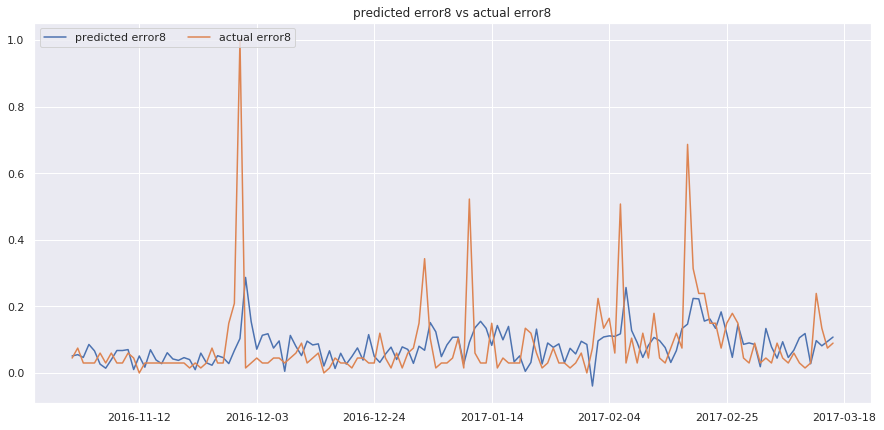

In [32]:
# Plot predicted and actual
plt.figure(figsize=(15, 7))
plt.plot(feature_count_var_scaled['error8'].tail(steps_to_predict), label="predicted error8") 
plt.plot(all_features_scaled['error8'].tail(steps_to_predict), label="actual error8")

# Titles, Legends and formatting
plt.title("predicted error8 vs actual error8")
plt.grid(True)
plt.legend(ncol=2, loc='upper left')
plt.show()

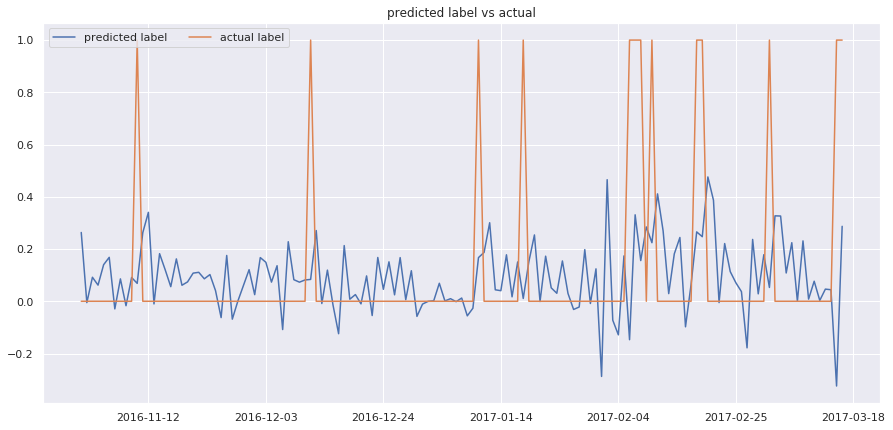

In [33]:
# Plot predicted and actual
plt.figure(figsize=(15, 7))
plt.plot(label_var.tail(steps_to_predict), label="predicted label") 
plt.plot(label.tail(steps_to_predict), label="actual label")

# Titles, Legends and formatting
plt.title("predicted label vs actual")
plt.grid(True)
plt.legend(ncol=2, loc='upper left')
plt.show()

## AUC for VAR algorithm

In [34]:
from sklearn.metrics import roc_auc_score

#actual_label = label.tail(dataset_test_length).head(steps_to_predict)
actual_label = label.tail(steps_to_predict)
predicted_label = label_var.tail(steps_to_predict)

# Calculate auc
roc_auc_score(actual_label, predicted_label) 

0.5967741935483871

### The ROC score for the VAR algorithm is at 0.597. It is slightty better than random guess.

From the figures above we can see that the prediction seems better for the errors than for the label. The error prediction is clearly following the same trend as the error it tries to predict.

For the label (equipment failure), it is slightly more difficult to predict and the trend is not as clear as for the error.

The VAR algorithm is a regression algorithm. Each signal is predicted according to a past version of itself and all the other signals. 

This algorithm is then solving this problem using a regression mechanism. This would be fine to predict all error signals as they are all numerical values that change through time. But the label is actually a category (equipment OK or not). Categories cannot be predicted in an optimal manner using a regression algorithm. That is, to my opinion, the limit of the VAR algorithm for this dataset.

# 6. Implementation of the selected model

The selected model is the RNN-Seq2Seq algorithm. It is not in sklearn but we will use another library called Keras for Deep Learning.

We could have chosen a simple many to one architecture to directly compare with the previous benchmark implementation. Many to one architecture consists in using many inputs to predict only one (As we are doing using the VAR algorithm).

Instead, we choose to have a many-to-many implementation (Seq2Seq) to take advantage of the power of RNNs to predict many successive values using many inputs. The number of inputs and predictions is, of course, independent from one another.

<img src="stationary_examples.png">

<img src="stationary_examples.png">

## RNN Seq2Seq Recap

RNNs consists of two layers:
- Encoder RNN: Process input sequence and returns it is internal state and its outputs (ignored here)
- Decoder RNN: Predicts next outputs given the encoder state (See architecture below)

<img src="stationary_examples.png">

In order to use the RNN, we need to be able to feed it with data. Our objective is to use the same data that was used in the benchmark algorithm (all error counts + max ticks + min ticks + mean ticks + std_dev).

The Algorithm will figure out the link between all these elements and hopefully find a way to predict equipment failure one day (or more) in advance.

## Prepare RNN Inputs

Each RNN cell will receive all the data at once so we need to prepare the data. Each RNN cell input will be a concatenation of all errors + ticks + min + max + mean + std_dev.

The Decoder Cell output will be a label.

We already have all the features & labels in pandas dataframes but we will need to convert them in numpy arrays.

In [29]:
# Converting features and label to numpy array with type np.float32 (type needed to be able to train on GPUs)
X_train_np = X_train.values.astype(np.float32) 
y_train_np = y_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_test_np = y_test.values.astype(np.float32)
print(X_train_np.shape)
print(y_train_np.shape)
print(X_test_np.shape)
print(y_test_np.shape)

# X_train_np_test = X_train.reset_index(drop=True).reset_index().values.astype(np.float32)#TO REMOVE
# y_train_np_test = y_train.reset_index(drop=True).reset_index().values.astype(np.float32)#TO REMOVE
# print(X_train_np_test.shape)#TO REMOVE
# print(y_train_np_test.shape)#TO REMOVE
#print(all_features_nparray_test)
#print(label_nparray_test)

(546, 126)
(546, 1)
(137, 126)
(137, 1)


Now that the data has the right format, we need to create batches for the algorithm to train.

Our dataset is very small, so we will apply a trick here which is generating infinite batches from a finite small dataset (data augmentation).

The trick will consist in a generating function that will provide random batches of data from the existing dataset. Everytime the function is called, it will generate a batch by randomly choosing an offset from which the batch will start. Thus creating infinite batches from a finite dataset.

This will be used to train the algorithm because Deep Learning needs many batches to train.

In [30]:
# dataset_train_length = len(X_train.index)
# dataset_test_length = len(X_test.index)
# print(dataset_train_length)
# print(dataset_test_length)

### Generator Function

In [31]:
import random

def batch_generator(features_array, 
                    label_array, 
                    steps_per_epoch = 100,
                    batch_size = 50, 
                    input_sequence_length = 5, 
                    output_sequence_length = 1):
    """ 
    Generates batches from the fixed elements of the dataset (features_array & label_array).
    Called at each step by the RNN algorithm. Will run with a seed in order to generate same sequence for every epoch.
    Yields a tuple containing:
    - ([encoder_inputs, decoder_inputs], decoder_outputs)
        encoder_inputs shape: (batch_size, input_sequence_length, 126) - set up from features_array data(shape: (batch_size, 126)
        decoder_inputs shape: (batch_size, output_sequence_length, 1) - all values are set 0 (decoder inputs not used here)
        decoder_outputs shape (batch_size, output_sequence_length, 1) - set up from label_array data(shape: (batch_size, 1))
    """
    # Data taken at each step for features (batch_size*input_sequence_length) 
    # should be at most half of actual dataset size (features_array.shape[0]/2) to avoid having similar data for each step
    # We decided to have at most half of the dataset returned at each call
    if not list(features_array) or not list(label_array):
        raise Exception('Empty array')
    elif batch_size <= 0:
        raise Exception('Batch_size cannot be negative nor 0')
    elif steps_per_epoch <= 0:
        raise Exception('Steps_per_epoch cannot be negative nor 0')
    elif input_sequence_length <= 0 or output_sequence_length <= 0:
        raise Exception('Input length cannot be negative or 0')
    elif (features_array.shape[0]/2) < (batch_size*input_sequence_length):
        raise Exception('Too many features taken at each step, reduce batch_size and/or input_input_sequence_length')
    elif input_sequence_length < output_sequence_length :
        raise Exception('This generator does not cover cases when input sequence is greater than output sequence')
    else:
        while True:
            # Reset seed to obtain same sequences from epoch to epoch
            random.seed(42)
            
            for _ in range(steps_per_epoch):
                # Renaming for more readability
                bs = batch_size
                isq = input_sequence_length
                osq = output_sequence_length
                
                # Generating pseudo random int that will be the starting index
                start = random.randint(0, features_array.shape[0] - ((bs*isq)+isq))
                #start = features_array.shape[0] - ((bs*isq)+isq) # for tests
                # Generating outputs
                encoder_input = features_array[start:(start+(bs*isq)), :].reshape(bs, isq, features_array.shape[1])
                decoder_output = label_array[start+isq:(start+isq+(bs*isq)), :].reshape(bs, isq, label_array.shape[1])[:,:osq,:]
                decoder_input = np.zeros((decoder_output.shape[0], decoder_output.shape[1], label_array.shape[1])) 
                ###TODO: Document the above lines
                
                yield ([encoder_input, decoder_input], decoder_output)

In [32]:
# # import numpy as np  
# feat_array_test = np.reshape(np.repeat(np.arange(546), 6), (546, 6))
# lab_array_test = np.reshape(np.repeat(np.arange(546), 1), (546, 1))

# print(feat_array_test)
# print(lab_array_test)

In [33]:
# #Quick test with some values
# gen = batch_generator(feat_array_test, lab_array_test, steps_per_epoch = 5, batch_size = 100, 
#                       input_sequence_length = 2, 
#                       output_sequence_length = 1)

# #print(len(next(gen)))

# for i, data in enumerate(gen):
    
#     start, inputs, decOutput = data
#     print("i: {}".format(i))
#     print("start: {}".format(start))
#     print("encoder input shape: {}".format(inputs[0].shape))
#     print(inputs[0])
#     print("decoder input shape: {}".format(inputs[1].shape))
#     print(inputs[1])
#     print("decoder output shape: {}".format(decOutput.shape))
#     print(decOutput)
#     if i > 9:
#         break
    

In [34]:
# #Quick test with other values
# gen = batch_generator(feat_array_test, lab_array_test, steps_per_epoch = 10, batch_size = 60, 
#                       input_sequence_length = 4, 
#                       output_sequence_length = 4)

# for i, data in enumerate(gen):
#     start, inputs, decOutput = data
#     print("start: {}".format(start))
#     print("encoder input shape: {}".format(inputs[0].shape))
#     print(inputs[0])
#     print("decoder input shape: {}".format(inputs[1].shape))
#     print(inputs[1])
#     print("decoder output shape: {}".format(decOutput.shape))
#     print(decOutput)
#     if i > 9:
#         break

### Function to prepare Validation inputs and Inference inputs of the RNN

In [35]:
# This function will rearrange input data before using it in the model validation & prediction
# From 2D data (batch_size, data_dimension) to 3D data (batch_size, input_sequence_length, data dimension)
def prepare_3d_feature_data(previous_array, current_array, input_sequence_length, output_sequence_length):
    """
    - previous_array: 2D validation feature data (test use case) or 2D training data (validation use case) 
    - current_array: 2D test feature data (test use case) or 2D validation feature data (validation use case)  
    ==================================================================================
    Inference works like this (ex: input_sequence_length = 4 and output_sequence_length = 2) :
    (in1, in2, in3, in4) -> (pred5, pred6)
    (in5, in6, in7, in8) -> (pred9, pred10)
    pred7, pred8 is missing
    Given (in1, in2, in3, in4), (in5, in6, in7, in8) we need to generate the following data:
    (in1, in2, in3, in4), (in3, in4, in5, in6), (in5, in6, in7, in8), (in7, in8, in9, in10)
             |                     |                     |                     | 
       (pred5, pred6)       (pred7, pred8)         (pred9, pred10)      (pred11, pred12)
    That will give us continuous predictions that we need the model to generate
    Important note: The previous_array is used here as we will ned to take the last 4 elements and prepend them
    to the test data. This way we will be able to apply the model on these 4 elements and it will give the first 2 
    predictions.
    The algorithm used here will generate additional elements
    (they will be removed in the predict function just after the model predictions).
    The number of additional elements depends on the input_sequence_length, output_sequence_length combination
    """
    #input data length must be a multiple of input_sequence_length
    if len(current_array) % input_sequence_length != 0:
        raise Exception('input_sequence_length must be a multiple of current_array')
    elif len(previous_array) < input_sequence_length:
        raise Exception('previous_array is too small, last {} items needed - please check if mistake'.format(input_sequence_length))
        
    else:
        # Get last "input_sequence_length" elements of training data
        last_elts = previous_array[-input_sequence_length:]
        # Prepend the last "input_sequence_length" elements
        prepended_current_array = np.insert(current_array, 0, last_elts, axis=0)
        
        # Special case when input_sequence_length = output_sequence_length (no offset), we can return the reshaped input_data
        if input_sequence_length == output_sequence_length:
            # Return the test data prepended with the last "input_sequence_length" elements
            # Reshape it in order to send the right format to the Model (batch_size, input_sequence_length, 126)
            return np.reshape(prepended_current_array, (-1, input_sequence_length, current_array.shape[1]))
        
        else:
            offset = 0
            new_current_array = []
            while (offset + input_sequence_length) <= len(prepended_current_array):
                new_current_array.append(prepended_current_array[offset:offset+input_sequence_length])
                offset = offset + output_sequence_length
            # Reshape data in order to send the right format to the Model (batch_size, input_sequence_length, 126)
            return np.reshape(new_current_array, (-1, input_sequence_length, current_array.shape[1]))
        

In [36]:
# #Quick test (input_sequence_length = output_sequence_length)
# test_sample_size = 124 #126: isq=1, 2,3,6 - 125: isq=5 - 124: isq=4
# train = feat_array_test[:-test_sample_size,:]
# test = feat_array_test[-test_sample_size:,:]
# print(train.shape)
# print(test.shape)
# print(train)
# print(test)
# a = prepare_feature_data(train, test, 4, 4)
# print(a.shape)
# print(a)

In [37]:
# #Quick test (input_sequence_length != output_sequence_length)
# test_sample_size = 124 #126: isq=1, 2,3,6 - 125: isq=5 - 124: isq=4
# train = feat_array_test[:-test_sample_size,:]
# test = feat_array_test[-test_sample_size:,:]
# print(train.shape)
# print(test.shape)
# print(train)
# print(test)
# a = prepare_feature_data(train, test, 4, 3)
# print(a.shape)
# print(a)

### Function to prepare Validation labels

In [38]:
# This function will rearrange label data for the model validation
# From 2D data (batch_size, data_dimension) to 3D data (batch_size, output_sequence_length, data dimension)
def prepare_3d_label_data( train_feature_array, 
                           validation_feature_array, 
                           validation_label_array, 
                           input_sequence_length, 
                           output_sequence_length):
    """
    - train_feature_array: 2D training feature data (to be passed to prepare_feature_data function)
    - validation_feature_array: 2D validation feature data
    - validation_label_array: 2D validation label data
    ==================================================================================
    Training works like this (ex: input_sequence_length = 4 and output_sequence_length = 2) :
    (in1, in2, in3, in4) -> (pred5, pred6)
    (in5, in6, in7, in8) -> (pred9, pred10)
    pred7, pred8 is missing
    Given (in1, in2, in3, in4), (in5, in6, in7, in8) we need to generate the following data:
    (in1, in2, in3, in4), (in3, in4, in5, in6), (in5, in6, in7, in8), (in7, in8, in9, in10)
             |                     |                     |                     | 
       (pred5, pred6)       (pred7, pred8)         (pred9, pred10)      (pred11, pred12)
    That will give us continuous labels that the model needs
    Validation input will look like: (pred5, pred6, pred7, pred8, pred9, pred10, pred11, pred12)
    This function will have to reshape it and make sure it has the right shape:
    (pred5, pred6, pred7, pred8, pred9, pred10, pred11, pred12)
                                |
    ((pred5, pred6), (pred7, pred8), (pred9, pred10), (pred11, pred12))
    The challenge here is that the expected model results might have a different size from the validation_label data
    (model result array of shape (batch_size=50, output_sequence_length=2, 1) -> 100 elements, and we have in input
    validation label data of shape (96, 1) -> 96 elements).
    We will then need to generate a model_validation_label_array that might have additional elements at 0 
    (if expected model results size > validation_label size)
    """
    # Prepare feature data
    feature_data = prepare_3d_feature_data(train_feature_array, 
                                           validation_feature_array, 
                                           input_sequence_length, 
                                           output_sequence_length)
    
#     print('feature_data shape: ({}, {}, {})'.format(feature_data.shape[0], 
#                                                     feature_data.shape[1],
#                                                     feature_data.shape[2]))
    
    # Get batch size generated from features
    batch_size = feature_data.shape[0]
    
    # Calculate difference bw target size (nb of elements in validation) 
    # and expected size from model (batch_size*output_sequence_length)
    diff = validation_label_array.shape[0] - (batch_size*output_sequence_length)
    
    # Model generates more data than validation_label_array
    if diff < 0:
        # Append zeros
        extra_zeros = np.zeros((abs(diff), validation_label_array.shape[1]))
        validation_label_array_appended = np.append(validation_label_array, extra_zeros)
        
        # Reshape and return model_validation_array
        return np.reshape(validation_label_array_appended, (batch_size, 
                                                            output_sequence_length, 
                                                            validation_label_array.shape[1]))
        
    
    # Model generates exactly the same amount of data than validation_label_array (do nothing)
    elif diff == 0:
        # Reshape and return model_validation_array
        return np.reshape(validation_label_array, ( batch_size, 
                                                    output_sequence_length, 
                                                    validation_label_array.shape[1]))
    
    # Problem
    else:
        raise Exception('Model generates less data than validation data size')
        

In [39]:
# #Quick test (input_sequence_length = output_sequence_length)
# test_sample_size = 112 #xxx: isq=1, 2,3,6 - xxx: isq=5 - 112: isq=4
# val_idx = int(test_sample_size*0.9)
# train_feature = feat_array_test[:val_idx,:]
# val_feature = feat_array_test[val_idx:test_sample_size,:]
# val_lab = lab_array_test[val_idx:test_sample_size,:]
# print(train_feature.shape)
# print(val_feature.shape)
# print(val_lab.shape)
# print(train_feature)
# print(val_feature)
# print(val_lab)
# a = prepare_label_data(train_feature, val_feature, val_lab, 4, 4)
# print(a.shape)
# print(a)

In [40]:
# #Quick test (input_sequence_length != output_sequence_length)
# test_sample_size = 112 #xxx: isq=1, 2,3,6 - xxx: isq=5 - 112: isq=4
# val_idx = int(test_sample_size*0.9)
# train_feature = feat_array_test[:val_idx,:]
# val_feature = feat_array_test[val_idx:test_sample_size,:]
# val_lab = lab_array_test[val_idx:test_sample_size,:]
# print(train_feature.shape)
# print(val_feature.shape)
# print(val_lab.shape)
# print(train_feature)
# print(val_feature)
# print(val_lab)
# a = prepare_label_data(train_feature, val_feature, val_lab, 4, 1)
# print(a.shape)
# print(a)

### Fonction for Data update & preparation (train, val, test)

In [41]:
# Utils function
def get_right_size(dataset_size, multiple, seq_len):
    # size greater or equal than product of multiple and seq_len
    if dataset_size - (multiple*seq_len) >= 0:
        ret_size = multiple*seq_len
    # size smaller than product of multiple and seq_len   
    else:
        ret_size = (multiple-1)*seq_len
        
    return ret_size


# DUE TO THE REQUIREMENTS OF THE SEQ2SEQ ALGORITHM:
# - train dataset size should be a multiple of the RNN Seq2Seq input_sequence_length
# - validation dataset size should be a multiple of the RNN Seq2Seq input_sequence_length
# - test dataset size should be a multiple of the RNN Seq2Seq input_sequence_length
# WE NEED A FUNCTION TO GIVE USE THE BEST SPLIT GIVEN:
# - input_sequence_length
# - train dataset 
# - validation datset
# - test datase
# DUE TO THE NATURE OF THE DATA (TIME SERIES), THE DATASETS MUST BE CONTINUOUS
def prepare_2d_splits(train_dataset, test_dataset, validation_split, input_sequence_length):
    """
    From the original datasets (train & test) and the validation split:
    - train_dataset: training array (feature or label)
    - test_dataset: test dataset (feature or label)
    - vaidation_split: fraction of training data to be used as validation (bw 0 and 1)
    - input_sequence_length: input_sequence_length for the Seq2Seq model
    
    Returns:
    - train_dataset: updated according to the validation split and the model requirements
    - validation_dataset: updated according to the validation split and the model requirements
    - test_dataset: updated according to the model requirements
    """
    # Initialize return values
    split_idx = int(train_dataset.shape[0]*(1-validation_split))
    ret_train_dataset = train_dataset[:split_idx, :]
    ret_val_dataset = train_dataset[split_idx:, :]
    ret_test_dataset = test_dataset
    #print("split idx: {}".format(split_idx))
    
    # Sizes
    train_dataset_size = ret_train_dataset.shape[0]
    val_dataset_size = ret_val_dataset.shape[0]
    test_dataset_size = ret_test_dataset.shape[0]
    #print("sizes: {} {} {}".format(train_dataset_size, val_dataset_size, test_dataset_size))
    
    # All sizes OK
#     if (train_dataset_size % input_sequence_length == 0 and 
#         val_dataset_size % input_sequence_length == 0 and
#         test_dataset_size % input_sequence_length == 0):
#         return (ret_train_dataset, ret_val_dataset, ret_test_dataset)
    
    # Concatenate train & test
    dataset = np.concatenate((train_dataset, test_dataset), axis=0)
    
    # Calculate multiples
    multiple_train = int(train_dataset_size/input_sequence_length)
    multiple_val = int(val_dataset_size/input_sequence_length)
    multiple_test = int(test_dataset_size/input_sequence_length)
    #print("multiples: {} {} {}".format(multiple_train, multiple_val, multiple_test))
    
    # train data size NOK
    #if train_dataset_size % input_sequence_length != 0:
    train_dataset_size = get_right_size(train_dataset_size, multiple_train, input_sequence_length)
    #print("sizes in train: {} {} {}".format(train_dataset_size, val_dataset_size, test_dataset_size))      
    ret_train_dataset = dataset[:train_dataset_size, :]
    
    # validation data size NOK
    #if val_dataset_size % input_sequence_length != 0:
    val_dataset_size = get_right_size(val_dataset_size, multiple_val, input_sequence_length)
    #print("sizes in val: {} {} {}".format(train_dataset_size, val_dataset_size, test_dataset_size))
    ret_val_dataset = dataset[train_dataset_size:(train_dataset_size+val_dataset_size), :]
        
    # test data size NOK
    #if test_dataset_size % input_sequence_length != 0:
    test_dataset_size = get_right_size(test_dataset_size, multiple_test, input_sequence_length)
    #print("sizes in test: {} {} {}".format(train_dataset_size, val_dataset_size, test_dataset_size))
    ret_test_dataset = dataset[(train_dataset_size+val_dataset_size):(train_dataset_size+val_dataset_size+test_dataset_size), :]
    
    return (ret_train_dataset, ret_val_dataset, ret_test_dataset)


In [42]:
# #Quick test
# X = np.reshape(np.repeat(np.arange(546+137), 6), (546+137, 6))
# y = np.reshape(np.repeat(np.arange(546+137), 1), (546+137, 1))
# X_train_for_test = X[:546, :]
# y_train_for_test = y[:546, :]

# X_test_for_test = X[546:, :]
# y_test_for_test = y[546:, :]

# print(X_train_for_test.shape)
# print(y_train_for_test.shape)

# print(X_test_for_test.shape)
# print(y_test_for_test.shape)

# new_X_train, new_X_val, new_X_test = prepare_2d_splits(X_train_for_test, 
#                                                        X_test_for_test, 
#                                                        0.1, 
#                                                        3)

# print(new_X_train.shape)
# print(new_X_train)
# print(new_X_val.shape)
# print(new_X_val)
# print(new_X_test.shape)
# print(new_X_test)

### Function to prepare AUC ROC Metric for Keras

In [43]:
#import scikit
import tensorflow as tf

def roc_auc(y_true, y_pred):
    """
    Function to be used as a metric for the model.
    Will also be used for EarlyStopping and ModelCheckpoint Callback (see Model below for more info).
    Simply returns the auc at the end of each epoch (will calculate auc on the whole dataset as end of epoch
    means we covered the whole dataset).
    """
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.float32)  

In [44]:
roc_auc(actual_label, predicted_label)

NameError: name 'actual_label' is not defined

## Model

In [45]:
import keras

Using TensorFlow backend.


In [46]:
import tensorflow as tf
sess = tf.Session()

In [47]:
from keras import backend as K
K.set_session(sess)

In [48]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[22. 28.]
 [49. 64.]]


### Hyperparameters

In [49]:
keras.backend.clear_session()

num_layers = 1
hidden_neuros = 32

layers = [hidden_neuros]*num_layers # [64 ..] Number of hidden neuros in each layer of the encoder and decoder
learning_rate = 0.001
decay = 0 # Learning rate decay
optimiser = keras.optimizers.Adam(lr=learning_rate, decay=decay) # Other possible optimiser "sgd" (Stochastic Gradient Descent)
dropout = 0.7 # % of neuros to turn off while training

num_input_features = 126 # The dimensionality of the input at each time step.
num_output_features = 1 # The dimensionality of the output at each time step.
# There is no reason for the input sequence to be of same dimension as the ouput sequence:
# Input has 126 features (erros, ticks, mean ...) while output label has 1 feature (machine OK or NOK)

loss = "binary_crossentropy" # Other loss functions are possible, see Keras documentation.
activation_dense = 'linear' #Activation function for the dense layer

# Regularisation isn't really needed for this application
lambda_regulariser = 0.000001 # Will not be used if regulariser is None
regulariser = None # Possible regulariser: keras.regularizers.l2(lambda_regulariser)

batch_size = 32
steps_per_epoch = 1000 # batch_size * steps_per_epoch = total number of training examples
epochs = 200

input_sequence_length = 3 # Length of the sequence used by the encoder
output_sequence_length = 1 # Length of the sequence predicted by the decoder

patience = int(epochs/10) # patience parameter for the Early Stopping Callback

validation_split = 0.1

### Final train, validation, test split

In [50]:
# Prepare 2d splits that complies with model requirements (right sizes)
X_train_2d, X_val_2d, X_test_2d = prepare_2d_splits(X_train_np, X_test_np, validation_split, input_sequence_length)
y_train_2d, y_val_2d, y_test_2d = prepare_2d_splits(y_train_np, y_test_np, validation_split, input_sequence_length) 

# print(X_train_2d.shape)
# print(y_train_2d.shape)
# print(X_val_2d.shape)
# print(y_val_2d.shape)
# print(X_test_2d.shape)
# print(y_test_2d.shape)


# Prepare validation_data needed during fit
X_val_3d = prepare_3d_feature_data(X_train_2d, X_val_2d, input_sequence_length, output_sequence_length)
# print(X_val_3d.shape)
y_val_3d = prepare_3d_label_data( X_train_2d, 
                                  X_val_2d, 
                                  y_val_2d, 
                                  input_sequence_length, 
                                  output_sequence_length)
# print(y_val_3d.shape)

# print(X_train.iloc[[0]]['error8'])
# print(X_train_np[0][7])
# print(X_train.iloc[[489]]['error8'])
# print(X_val_3d[1][2][7])
# print("====")
# # print(X_train.iloc[[541]]['error8'])
# print(X_train[540:543]['error8'])
# print(X_val_3d[54, :, 7])
# print("===========================")
# #print(X_train_np[543][8])
# print(y_train.iloc[[0]]['label'])
# print(y_train_np[0][0])
# print(y_train.iloc[[489]]['label'])
# print(y_val_3d[1][0][0])
# print("====")
# # print(X_train.iloc[[541]]['error8'])
# print(y_train[540:543]['label'])
# print(y_val_3d[52:55, :, :])

# Create a decoder input with same dimensions as decoder outputs (y_val_3d) and all values at 0
X_decoder_zeros_3d = (np.zeros((y_val_3d.shape[0], y_val_3d.shape[1], y_val_3d.shape[2]))).astype(np.float32)

# print(X_decoder_zeros_3d.shape)

### Encoder

In [51]:
with tf.device('/gpu:0'):
    # Define an input sequence.
    encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

    # Create a list of RNN Cells, these are then concatenated into a single layer
    # with the RNN layer.
    encoder_cells = []
    for hidden_neurons in layers:
        encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                   kernel_regularizer=regulariser,
                                                   recurrent_regularizer=regulariser,
                                                   bias_regularizer=regulariser,
                                                   dropout=dropout))

    encoder = keras.layers.RNN(encoder_cells, return_state=True)

    encoder_outputs_and_states = encoder(encoder_inputs)

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = encoder_outputs_and_states[1:]

### Decoder

In [52]:
with tf.device('/gpu:0'):
    # The decoder input will be set to zero (see batch_generator function above).
    decoder_inputs = keras.layers.Input(shape=(None, num_output_features))

    decoder_cells = []
    for hidden_neurons in layers:
        decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                   kernel_regularizer=regulariser,
                                                   recurrent_regularizer=regulariser,
                                                   bias_regularizer=regulariser,
                                                   dropout=dropout))

    decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

    # Set the initial state of the decoder to be the ouput state of the encoder.
    # This is the fundamental part of the encoder-decoder.
    decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

    # Only select the output of the decoder (not the states)
    decoder_outputs = decoder_outputs_and_states[0]

    # Apply a dense layer with linear activation to set output to correct dimension
    decoder_dense = keras.layers.Dense(num_output_features,
                                       activation=activation_dense,
                                       kernel_regularizer=regulariser,
                                       bias_regularizer=regulariser)


    decoder_outputs = decoder_dense(decoder_outputs)

    final_decoder_outputs = keras.layers.Dropout(dropout)(decoder_outputs)

### Create and compile Model

In [53]:
with tf.device('/gpu:0'):
    # Create Callbacks to be used during training
    # 1. Early Stopping: When an epoch training finishes, this callback is called and stops the training when the monitor value
    # stops improving (either increasing or decreasing - to be specified in parameters).
    # Here we will use a custom metric which will be the AUCROC result (which is actually what we are interested to improve here)
    # AUC ROC is not a loss function supported in Keras so we keep the standard binary_crossentropy and use AUC ROC as a metric.
    es = keras.callbacks.EarlyStopping (monitor='val_roc_auc', patience=patience, verbose=1, mode='max')

    # 2. Saving Best Model: When an epoch training finishes, this callback is called and saves the best model according to 
    # the monitor value (either increasing or decreasing - to be specified in parameters).
    # Here we will use a custom metric which will be the AUC ROC result (which is actually what we are interested to improve here)
    # AUC ROC is not a loss function supported in Keras so we keep the standard binary_crossentropy and use AUC ROC as a metric.
    mc = keras.callbacks.ModelCheckpoint("model/best/best_model.hdf5", monitor='val_roc_auc', verbose=1, save_best_only=True, mode='max')

In [54]:
with tf.device('/gpu:0'):
    model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
    model.compile(optimizer=optimiser, loss=loss, metrics=['binary_crossentropy']) # , roc_auc  - , callbacks=[es, mc]

In [55]:
with tf.device('/gpu:0'):
    model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 126)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
rnn_1 (RNN)                     [(None, 32), (None,  20352       input_1[0][0]                    
__________________________________________________________________________________________________
rnn_2 (RNN)                     [(None, None, 32), ( 4352        input_2[0][0]                    
                                                                 rnn_1[0][1]                      
          

### Fit Model to Data

In [56]:
# import numpy as np 
features_for_test = (np.reshape(np.repeat(np.arange(546+137), 126), (546+137, 126))).astype(np.float32)
labels_for_test = (np.reshape(np.repeat(np.arange(546+137), 1), (546+137, 1))).astype(np.float32)

enc_train_np = features_for_test[0:546, :]
enc_test_np = features_for_test[546:, :]

dec_train_np = labels_for_test[0:546, :]
dec_test_np = labels_for_test[546:, :]

enc_train_2d, enc_val_2d, enc_test_2d = prepare_2d_splits(enc_train_np, enc_test_np, validation_split, input_sequence_length)
dec_train_2d, dec_val_2d, dec_test_2d = prepare_2d_splits(dec_train_np, dec_test_np, validation_split, input_sequence_length)

print(enc_train_2d.shape)
print(enc_train_2d)
print(enc_val_2d.shape)
print(enc_val_2d)
print(enc_test_2d.shape)
print(enc_test_2d)
print(dec_train_2d.shape)
print(dec_train_2d)
print(dec_val_2d.shape)
print(dec_val_2d)

# Prepare validation_data needed during fit
enc_val_3d = prepare_3d_feature_data(enc_train_2d, enc_val_2d, input_sequence_length, output_sequence_length)
print(enc_val_3d.shape)
print(enc_val_3d)
dec_val_3d = prepare_3d_label_data( enc_train_2d, 
                                  enc_val_2d, 
                                  dec_val_2d, 
                                  input_sequence_length, 
                                  output_sequence_length)
print(dec_val_3d.shape)
print(dec_val_3d)

(489, 126)
[[  0.   0.   0. ...   0.   0.   0.]
 [  1.   1.   1. ...   1.   1.   1.]
 [  2.   2.   2. ...   2.   2.   2.]
 ...
 [486. 486. 486. ... 486. 486. 486.]
 [487. 487. 487. ... 487. 487. 487.]
 [488. 488. 488. ... 488. 488. 488.]]
(54, 126)
[[489. 489. 489. ... 489. 489. 489.]
 [490. 490. 490. ... 490. 490. 490.]
 [491. 491. 491. ... 491. 491. 491.]
 ...
 [540. 540. 540. ... 540. 540. 540.]
 [541. 541. 541. ... 541. 541. 541.]
 [542. 542. 542. ... 542. 542. 542.]]
(135, 126)
[[543. 543. 543. ... 543. 543. 543.]
 [544. 544. 544. ... 544. 544. 544.]
 [545. 545. 545. ... 545. 545. 545.]
 ...
 [675. 675. 675. ... 675. 675. 675.]
 [676. 676. 676. ... 676. 676. 676.]
 [677. 677. 677. ... 677. 677. 677.]]
(489, 1)
[[  0.]
 [  1.]
 [  2.]
 [  3.]
 [  4.]
 [  5.]
 [  6.]
 [  7.]
 [  8.]
 [  9.]
 [ 10.]
 [ 11.]
 [ 12.]
 [ 13.]
 [ 14.]
 [ 15.]
 [ 16.]
 [ 17.]
 [ 18.]
 [ 19.]
 [ 20.]
 [ 21.]
 [ 22.]
 [ 23.]
 [ 24.]
 [ 25.]
 [ 26.]
 [ 27.]
 [ 28.]
 [ 29.]
 [ 30.]
 [ 31.]
 [ 32.]
 [ 33.]
 [ 

In [57]:
# gen = batch_generator(  enc_train_2d, 
#                         dec_train_2d, 
#                         steps_per_epoch = steps_per_epoch,
#                         batch_size = batch_size, 
#                         input_sequence_length = input_sequence_length, 
#                         output_sequence_length = output_sequence_length)

# [enc_in, dec_in], dec_out = next(gen)

# X_zeros_decoder_3d = np.zeros((dec_val_3d.shape[0], dec_out.shape[1], dec_out.shape[2]))

# print(enc_val_3d.shape)
# print(enc_val_3d)

# print(dec_val_3d.shape)
# print(dec_val_3d)

# print(type(enc_in))
# print(enc_in.shape)

# print(type(dec_in))
# print(dec_in.shape)

# print(type(dec_out))
# print(dec_out.shape)

# print(X_zeros_decoder_3d.shape)

# model.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=([enc_val_3d, X_zeros_decoder_3d], dec_val_3d))#, validation_data=([enc_val_3d, X_zeros_decoder_3d], dec_val_3d)

In [58]:
# gen = batch_generator( X_train_2d, 
#                         y_train_2d, 
#                         steps_per_epoch = steps_per_epoch,
#                         batch_size = batch_size, 
#                         input_sequence_length = input_sequence_length, 
#                         output_sequence_length = output_sequence_length)

# print(type(next(gen)[0][0]))
# print(next(gen)[0][0].shape)

# print(type(next(gen)[0][1]))
# print(next(gen)[0][1].shape)

# print(type(next(gen)[1]))
# print(next(gen)[1].shape)

In [59]:
# print(tf.test.is_built_with_cuda())

In [60]:
# tf = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# tf.list_devices()

In [61]:
# # Creates a graph.
# a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
# b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
# c = tf.matmul(a, b)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # Runs the op.
# print(sess.run(c))

In [62]:
with tf.device('/gpu:0'):    
    train_data_generator = batch_generator( X_train_2d, 
                                            y_train_2d, 
                                            steps_per_epoch = steps_per_epoch,
                                            batch_size = batch_size, 
                                            input_sequence_length = input_sequence_length, 
                                            output_sequence_length = output_sequence_length)

    model.fit_generator(train_data_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=([X_val_3d, X_decoder_zeros_3d], y_val_3d)) #, validation_data=(X_val_3d, y_val_3d)

Epoch 1/200
1000/1000 [==============================] - 12s 12ms/step - loss: 0.6524 - binary_crossentropy: 0.6524 - val_loss: 1.3353 - val_binary_crossentropy: 1.3353
Epoch 2/200
1000/1000 [==============================] - 11s 11ms/step - loss: 0.5004 - binary_crossentropy: 0.5004 - val_loss: 1.3341 - val_binary_crossentropy: 1.3341
Epoch 3/200
 391/1000 [==========>...................] - ETA: 6s - loss: 0.4253 - binary_crossentropy: 0.4253

KeyboardInterrupt: 

In [67]:
keras.__version__

'2.2.4'

In [68]:
tf.__version__

'1.12.0'

### Predict Function for testing

In [120]:
# Creating a predict function that will use the model to predict in order to test
def predict(features_array_train, features_array_test, model_path, input_sequence_length, output_sequence_length):
    """
    Predicts time series according to the given model. 
    Rearranges the features_array_test to predict for a continuous window corresponding to the features_array_test.
    Explanation: 
    Our model takes "input_sequence_length" elements (ex: 4) and predicts the next "input_sequence_length" elements (ex: 2),
    it then takes the next 4 elements and predicts the next 2
    but here the next 2 outputs are not the just after the 2 predictions. There is an offset of 2 elements between the predictions:
    (in1, in2, in3, in4) -> (pred5, pred6)
    (in5, in6, in7, in8) -> (pred9, pred10)
    out7 and out8 are not available if we apply the model to the data directly. We need to prepare the data in order to
    also apply (in3, in4, in5, in6) -> (pred7, pred8)
    
    Other important note: 
    We can not just feed the model with the above data (in1, in2, in3, in4) and then (in5, in6, in7, in8) ....
    We need to feed the 4 elements prior to the needed predictions, the 4 elements before (in1, in2, in3, in4) in
    order to have (pred1, pred2) ...
    That is why the trainig data is an input to this function, we need the last 4 elements of the training data.
    - features_array_train: taining data of shape (number of elements in the training data, dimension of element)
    - features_array_test: testing data of shape (number of elements in the testing data, dimension of element) 
    - model_path: String pointing to the best model
    - input_sequence_length: used to prepare the data
    - output_sequence_length: use to prepare the data
    """
    # Preparing input data
    X_train_ready = prepare_input_data(features_array_train, 
                                       features_array_test, 
                                       input_sequence_length, 
                                       output_sequence_length)
    decoder_inputs = np.zeros((X_train_ready.shape[0], output_sequence_length, 1))
    
    # Applying model
    saved_model = keras.models.load_model('model/best/best_model.hdf5')
    y_pred = saved_model.predict([X_train_ready, decoder_inputs])
    
    # Reshaping from 3D to 2D (Model generates 3D predictions)
    y_pred_reshaped = np.reshape(y_pred, (-1, num_output_features)) # element dimension is num_output_features
                                  
    # Our data preparation implies an additional "output_sequence_length" predictions 
    # (ex: if output_sequence_length=2, the model will generate 2 additional predictions)
    # We need to remove them.
    return y_pred_reshaped[:-output_sequence_length]
    

### Evaluate model

array([[0, 0],
       [1, 1],
       [2, 2],
       [3, 3]])

## AUC for RNN Algorithm

In [221]:
from random import seed
from random import randint
from numpy import array
from math import ceil
from math import log10
from math import sqrt
from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
 
# generate lists of random integers and their sum
def random_sum_pairs(n_examples, n_numbers, largest):
	X, y = list(), list()
	for i in range(n_examples):
		in_pattern = [randint(1,largest) for _ in range(n_numbers)]
		out_pattern = sum(in_pattern)
		X.append(in_pattern)
		y.append(out_pattern)
	return X, y
 
# convert data to strings
def to_string(X, y, n_numbers, largest):
	max_length = n_numbers * ceil(log10(largest+1)) + n_numbers - 1
	Xstr = list()
	for pattern in X:
		strp = '+'.join([str(n) for n in pattern])
		strp = ''.join([' ' for _ in range(max_length-len(strp))]) + strp
		Xstr.append(strp)
	max_length = ceil(log10(n_numbers * (largest+1)))
	ystr = list()
	for pattern in y:
		strp = str(pattern)
		strp = ''.join([' ' for _ in range(max_length-len(strp))]) + strp
		ystr.append(strp)
	return Xstr, ystr
 
# integer encode strings
def integer_encode(X, y, alphabet):
	char_to_int = dict((c, i) for i, c in enumerate(alphabet))
	Xenc = list()
	for pattern in X:
		integer_encoded = [char_to_int[char] for char in pattern]
		Xenc.append(integer_encoded)
	yenc = list()
	for pattern in y:
		integer_encoded = [char_to_int[char] for char in pattern]
		yenc.append(integer_encoded)
	return Xenc, yenc
 
# one hot encode
def one_hot_encode(X, y, max_int):
	Xenc = list()
	for seq in X:
		pattern = list()
		for index in seq:
			vector = [0 for _ in range(max_int)]
			vector[index] = 1
			pattern.append(vector)
		Xenc.append(pattern)
	yenc = list()
	for seq in y:
		pattern = list()
		for index in seq:
			vector = [0 for _ in range(max_int)]
			vector[index] = 1
			pattern.append(vector)
		yenc.append(pattern)
	return Xenc, yenc
 
# generate an encoded dataset
def generate_data(n_samples, n_numbers, largest, alphabet):
	# generate pairs
	X, y = random_sum_pairs(n_samples, n_numbers, largest)
	# convert to strings
	X, y = to_string(X, y, n_numbers, largest)
	# integer encode
	X, y = integer_encode(X, y, alphabet)
	# one hot encode
	X, y = one_hot_encode(X, y, len(alphabet))
	# return as numpy arrays
	X, y = array(X), array(y)
	return X, y
 
# invert encoding
def invert(seq, alphabet):
	int_to_char = dict((i, c) for i, c in enumerate(alphabet))
	strings = list()
	for pattern in seq:
		string = int_to_char[argmax(pattern)]
		strings.append(string)
	return ''.join(strings)
 
# define dataset
seed(1)
n_samples = 1000
n_numbers = 2
largest = 10
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']
n_chars = len(alphabet)
n_in_seq_length = n_numbers * ceil(log10(largest+1)) + n_numbers - 1
n_out_seq_length = ceil(log10(n_numbers * (largest+1)))
# define LSTM configuration
n_batch = 10
n_epoch = 30
# create LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(n_in_seq_length, n_chars)))
model.add(RepeatVector(n_out_seq_length))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(n_chars, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# train LSTM
# for i in range(n_epoch):
# 	X, y = generate_data(n_samples, n_numbers, largest, alphabet)
# 	print(i)
# 	model.fit(X, y, epochs=1, batch_size=n_batch)
 
# # evaluate on some new patterns
# X, y = generate_data(n_samples, n_numbers, largest, alphabet)
# result = model.predict(X, batch_size=n_batch, verbose=0)
# # calculate error
# expected = [invert(x, alphabet) for x in y]
# predicted = [invert(x, alphabet) for x in result]
# # show some examples
# for i in range(20):
# 	print('Expected=%s, Predicted=%s' % (expected[i], predicted[i]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               45200     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 12)             612       
Total params: 76,012
Trainable params: 76,012
Non-trainable params: 0
_________________________________________________________________
None
